https://arxiv.org/pdf/1409.1556

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
print(f'available devices: {torch.cuda.device_count()}')
print(f'current device: { torch.cuda.current_device()}')
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i))

available devices: 1
current device: 0
_CudaDeviceProperties(name='NVIDIA A100-PCIE-40GB', major=8, minor=0, total_memory=40338MB, multi_processor_count=108)


# with connections

In [3]:
class CustomCNN(nn.Module):
    def __init__(self, input_size, conv_layers, output_size):
        super(CustomCNN, self).__init__()

        self.conv_layers = nn.ModuleList()
        self.flatten_layers = nn.ModuleList()
        in_channels = 3

        self.current_size = 64
        self.intermediate_sizes = []

        for (out_channels, kernel_size, stride, padding,pooling_kernel,pooling_stride) in conv_layers:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
            self.conv_layers.append(conv)
            self.conv_layers.append(nn.ReLU())
            if(pooling_kernel>0):
              self.conv_layers.append(nn.MaxPool2d(kernel_size=pooling_kernel, stride=pooling_stride))

            self.current_size = (self.current_size - kernel_size + 2 * padding) // stride + 1
            if(pooling_kernel>0):
              self.current_size = (self.current_size - pooling_kernel) // pooling_stride + 1
              self.intermediate_sizes.append((out_channels, self.current_size, self.current_size))
            in_channels = out_channels

        # Compute the flatten size
        self.flatten_size = 0
        for (out_channels, size, _) in self.intermediate_sizes:
            self.flatten_size += out_channels * size * size

        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, 4096),
            nn.ReLU(),
            nn.Linear(4096,1000),
            nn.ReLU(),
            nn.Linear(1000,10)
        )
        

    def forward(self, x):
        intermediate_outputs = []

        for i, layer in enumerate(self.conv_layers):
            x = layer(x)
            if isinstance(layer, nn.MaxPool2d):
                intermediate_outputs.append(x.view(x.size(0), -1))

        concatenated = torch.cat(intermediate_outputs, dim=1)
        x = self.fc(concatenated)
        
        return x

# without connections

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
class CustomCNN(nn.Module):
    def __init__(self, input_size, conv_layers, output_size):
        super(CustomCNN, self).__init__()

        self.conv_layers = nn.ModuleList()
        in_channels = 3

        self.current_size = 64

        for (out_channels, kernel_size, stride, padding, pooling_kernel, pooling_stride) in conv_layers:
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding))
            self.conv_layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
            if pooling_kernel > 0:
                self.conv_layers.append(nn.MaxPool2d(kernel_size=pooling_kernel, stride=pooling_stride))
                self.current_size = (self.current_size - pooling_kernel) // pooling_stride + 1

            # Update current size for the convolution layer
            self.current_size = (self.current_size - kernel_size + 2 * padding) // stride + 1
            in_channels = out_channels

        # Compute the flatten size based on the final feature map size
        self.flatten_size = in_channels * self.current_size * self.current_size

        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.Sigmoid(),
            nn.Linear(512, output_size)
        )

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)

        # Flatten the output
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# dataloading and preprocessing

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 32
# channels, kernel, stride, padding, pooling kernel size, pooling stride
# len(conv_layers) == no of convolution layers
conv_layers = [
    (64, 3, 1, 1,0,1),
    (64, 3, 1, 1,2,2),
    (128, 3, 1, 1,0,1),
    (128, 3, 1, 1,2,2),
    (256, 3, 1, 1,0,1),
    (256, 3, 1, 1,0,1),
    (256, 3, 1, 1,2,2),
    (512, 3, 1, 1,0,1),
    (512, 3, 1, 1,0,1),
    (512, 3, 1, 1,2,2),
    (512, 3, 1, 1,0,1),
    (512, 3, 1, 1,0,1),
    (512, 3, 1, 1,2,2)
]

output_size = 10
batch_size = 16
learning_rate = 1e-4
num_epochs = 15

# Load MNIST dataset
transform = transforms.Compose([
    transforms.Resize(64), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = CustomCNN(input_size, conv_layers, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)

Files already downloaded and verified
Files already downloaded and verified
CustomCNN(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

## TRAINING

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) 
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/15, Loss: 1.2732
Epoch 2/15, Loss: 0.8119
Epoch 3/15, Loss: 0.4768
Epoch 4/15, Loss: 0.1927
Epoch 5/15, Loss: 0.0794
Epoch 6/15, Loss: 0.0562


## Training accuracy

In [9]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device),labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the training images: {accuracy:.2f}%')


Accuracy of the network on the training images: 91.53%


## Testing sk learn

In [10]:
from sklearn.metrics import classification_report
class_names = test_dataset.classes
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)


              precision    recall  f1-score   support

    airplane       0.87      0.76      0.81      1000
  automobile       0.90      0.90      0.90      1000
        bird       0.87      0.59      0.70      1000
         cat       0.54      0.67      0.60      1000
        deer       0.76      0.80      0.78      1000
         dog       0.66      0.72      0.69      1000
        frog       0.80      0.89      0.84      1000
       horse       0.91      0.77      0.84      1000
        ship       0.87      0.93      0.90      1000
       truck       0.86      0.89      0.88      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



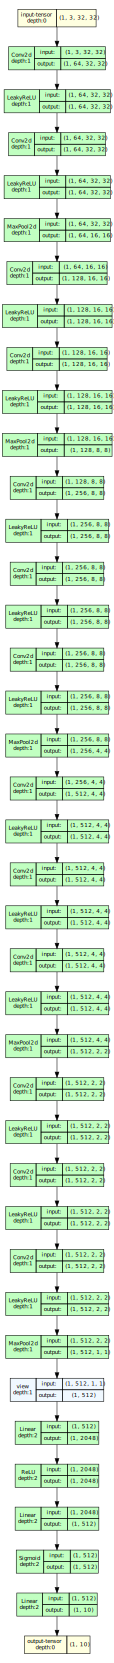

In [3]:
from torchview import draw_graph
model_graph = draw_graph(model, torch.zeros(1, 3, input_size, input_size))
model_graph.visual_graph